# Feature Engineering with `tidymodels`

In this tutorial, we will learn about resampling and feature engineering
with the `rsample` and `recipes` packages from `tidymodels`
<br>
<br>
<p align="center">
<img 
  src="./files/feature_engineering_process.png" 
  alt="Data Resampling" 
  width="auto"
  height="auto"
/>
</p>

<br>
Image source:

[@allisonhorst](https://allisonhorst.com/)

# Data Resampling

The first step in fitting a machine learning algorithm involves
splitting our data into training and test sets as well as processing our
data into a numeric feature matrix.

<br>

<p align="center">
<img 
   src="./files/training_test_data.png"
   width="392"
/img>
</p>

<br>

<br>

In machine learning, splitting data into training and test sets is known
as **data resampling**, or more generally as **cross validation**. This is an
important step in the model fitting process because it allows us to
estimate how our trained machine learning algorithms will perform on new
data.

The ultimate goal for any machine learning algorithm is to provide
accurate predictions on new, previously unseen data.

Resampling is achieved with the `rsample` package from `tidymodels`. To
demonstrate how this done, let's import the `tidymodels` package and the
`employee_data`.

The `tidymodels` package loads the core machine learning packages that
we will be using this semester, including `rsample`, `recipes`,
`parsnip`, `yardstick`, `dials`, `tune`, and `workflows`. Each one of
these packages serves a specific role in the modeling process. This
tutorial will focus on resampling with `rsample` and feature engineering
with `recipes`.

In [1]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1      ✔ recipes      1.0.3 
✔ dials        1.1.0      ✔ rsample      1.1.0 
✔ dplyr        1.0.10     ✔ tibble       3.1.8 
✔ ggplot2      3.4.0      ✔ tidyr        1.2.1 
✔ infer        1.0.3      ✔ tune         1.0.1 
✔ modeldata    1.0.1      ✔ workflows    1.1.2 
✔ parsnip      1.0.3      ✔ workflowsets 1.0.0 
✔ purrr        0.3.5      ✔ yardstick    1.1.0 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



In [2]:
employee_data <- readRDS(url('https://gmubusinessanalytics.netlify.app/data/employee_data.rds'))

<br> 

The code below creates a subset of the `employee_data` with select
columns and a new `employee_id` variable. This is so that we can easily
demonstrate the use of the `recipes` package in the next section.

<br>


In [3]:
employee_df <- 
  employee_data %>% 
  select(left_company, job_level, salary, 
         weekly_hours, miles_from_home)

# View results
employee_df


left_company,job_level,salary,weekly_hours,miles_from_home
<fct>,<fct>,<dbl>,<dbl>,<int>
Yes,Director,118680.74,56,1
No,Senior Manager,85576.44,42,8
Yes,Associate,46235.79,56,2
No,Director,117226.84,50,3
No,Associate,36634.73,46,2
No,Senior Manager,83519.59,48,2
No,Senior Manager,88555.65,44,3
No,Director,122280.88,47,24
No,Senior Manager,94642.18,50,23


## Data Splitting

The `initial_split()` function from the `rsample`package is used for
generating a data split object with instructions for randomly assigning
rows from a data frame to a training set and test set. Once the object
is created, we can use the `training()` and `testing()` functions to
obtain the two data frames from the object.

When splitting data, it is important to use the `set.seed()` function
before calling `initial_split()`. The `set.seed()` function takes any
integer as an argument and sets the random number generator in `R` to a
specific starting point. When this is done, the data split will be
random the first time our code is executed. Every execution afterwards,
will produce the same data split. This guarantees reproducibility.

The `initial_split()` function takes three important arguments, our
data, the proportion of rows to add to our training set (`prop`), and
the variable to use for stratification, `strata`.

The default `prop` value is 0.75. The `strata` argument should contain
the outcome variable that we are interesting in predicting. In our case,
this is `left_company`. Stratification ensures that there are an equal
proportion of `left_company` values in the training and test sets.

## Creating a Data Split Object

First, let's create a data split object named `employee_split`

<br>


In [4]:
# Set the random seed
set.seed(314)

employee_split <- initial_split(employee_df, prop = 0.75, 
                                strata = left_company)

<br>

If we print the **employee_split** object, we see that we have 1,103 rows
in our training data (known as `Analysis` in `rsample`) and 369 rows in
the test data (known as `Assess` in `rsample`)

In [5]:
employee_split

<Training/Testing/Total>
<1101/369/1470>

## Extracting Training and Test Sets

To create training and test data frames from our **_employee_split_** object, we must pass **_employee_split_** to the _**training()**_ and **_testing()_** functions.

The code below shows how to do this with the **_%>%_** operator. I have named the resulting data frames **_employee_training_** and **_employee_test_**.

<br>

When we create the training data, notice that the resulting data frame
has 1,103 rows and a random subset of the employees are included.

In [6]:
# Generate a training data frame
employee_training <- 
  employee_split %>% 
  training()

# View results
employee_training


left_company,job_level,salary,weekly_hours,miles_from_home
<fct>,<fct>,<dbl>,<dbl>,<int>
No,Director,117226.84,50,3
No,Senior Manager,83519.59,48,2
No,Senior Manager,88555.65,44,3
No,Director,122280.88,47,24
No,Senior Manager,94642.18,50,23
No,Director,122820.53,46,16
No,Manager,69565.51,48,15
No,Associate,41985.50,48,26
No,Director,117368.60,48,19


<br>

Our test set has 369 rows. Now we are ready to begin our feature
engineering steps on the training data.

In [7]:
# Generate a training data frame
employee_test <- 
  employee_split %>% 
  testing()

# View results
employee_test


left_company,job_level,salary,weekly_hours,miles_from_home
<fct>,<fct>,<dbl>,<dbl>,<int>
No,Senior Manager,85576.44,42,8
No,Associate,36634.73,46,2
No,Director,124537.85,51,27
Yes,Manager,63876.58,57,24
No,Senior Manager,84196.93,52,2
No,Director,116974.14,49,7
Yes,Senior Manager,93320.48,57,1
No,Senior Manager,82753.17,55,2
No,Director,122196.65,46,1


# Feature Engineering

Feature engineering includes all transformations that take a training data set and turn it into a **numeric feature matrix**.

Typical steps include:

-   Scaling and centering numeric predictors
-   Removing skewness from numeric variables
-   One-hot and dummy variable encoding for categorical variables
-   Removing correlated predictors and zero variance variables
-   Imputing missing data

<br>
<br>
<p align="center">
<img 
  src="./files/feature_engineering.jpg" 
  width="450"
/img>
</p>
Feature engineering steps should be trained on the **training data**. This includes things such as learning the means and standard deviations to apply in standardizing numeric predictors.

Once these are calculated in the training data, the same transforms are performed on the test data.

This way, the test data is completely removed from the training process and can serve as an independent assessment for model performance.

## Specify a Recipe

<br>
<p align="center">
<img 
  src="./files/specify_variables.png" 
  width="250"
/img>
</p>

<br>

The first step in build a feature engineering pipeline with the **_recipes_** package is to specify a blueprint for processing data and assigning roles to each column of the training data.

This is done with the **_recipe()_** function. This function takes two important arguments:

-   a model formula
-   a data frame or tibble for training the recipe

<br>

Model formulas in `R` have the following form:

```
outcome ~ predictor_1 + predictor_2 + ...
```

<br>

The outcome variable is on the left side of the `~` followed by all
predictors separated by a `+` on the righthand side.

For example, in our `employee_training` data, we are interested in
predicting whether an employee will leave the company. Our response
variable is `left_company`. We would like to use all other variables as
predictors. The way to specify this in an `R` formula is as follows:

```
left_company ~ job_level + salary + weekly_hours + miles_from_home
```

<br>

Typically, model formulas are written using shorthand notation. When we
type `left_company ~ .`, we are telling `R` that `left_company` is the
response variable and all other variables should be used as predictors.

This saves us from have to type out each predictor variable separated by
a `+`.

Let's specify our feature engineering recipe using the
`employee_training` data and the `recipe()` function. We will name our
`recipe` object `employee_recipe`

In [8]:
employee_recipe <- recipe(left_company ~ .,
                          data = employee_training)

<br>

To explore the variable roles in our recipe, we can pass our recipe
object to the `summary()` function. This will return a data frame with 4
columns. The important columns are `variable`, `type`, and `role`.

The `variable` column lists all the columns in the input data,
`employee_training` in this case.

The `type` column lets us know what data type each variable has in our
training data.

And finally, the `role` column specifies the various roles that the
`recipe()` function assigned to each variable based on our model
formula.

Notice that since we used `left_company ~ .` as our formula, the
`left_company` variable is assigned as an `outcome` variable while all
others are assigned as `predictor` variables.

In [32]:
summary(employee_recipe)

variable,type,role,source
<chr>,<list>,<chr>,<chr>
job_level,"factor , unordered, nominal",predictor,original
salary,"double , numeric",predictor,original
weekly_hours,"double , numeric",predictor,original
miles_from_home,"integer, numeric",predictor,original
left_company,"factor , unordered, nominal",outcome,original


## Processing Numeric Variables

<br>
<p align="center">
<img 
  src="./files/define_steps.png" 
  width="250"
  height="auto"
  align="center"
/>
</p>
<br>

Once we have specified a recipe with a formula, data, and correct
variables roles, we can add data transformation steps with a series of
`step()` functions. Each `step()` function in the `recipes` package
provides functionality for different kinds of common transformations.

### Centering and Scaling
<br>
<br>
<p align="center">
<img 
   src="./files/scaling_variables.png"
   width="450"
/img>
</p>

<br>
<br>

Let's begin with the simple task of centering and scaling numeric predictor variables. We have been doing this when we subtracted the mean and divided by the standard deviation in our previous tutorials.

The associated `step()` functions for this task are `step_center()` and
`step_scale()`. The `step_center()` function subtracts the column mean
from a variable and `step_scale()` divides by the standard deviation.

Each successive `step()` function adds a pre-processing step to our
recipe object **in the order that they are provided**.

All `step()` functions take a recipe as the first argument, and one or
more variables on which to apply the transformation.

Let's see what adding these step functions does to our recipe object. We
see that we get an updated recipe object as the output with instructions
for centering and scaling our numeric columns.

In [10]:
employee_recipe %>% 
  step_center(salary, weekly_hours, miles_from_home) %>% 
  step_scale(salary, weekly_hours, miles_from_home)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Centering for salary, weekly_hours, miles_from_home
Scaling for salary, weekly_hours, miles_from_home

<br>

But how can we obtain the results of the transformations on our
`employee_training` data frame? We must use the `prep()` and `bake()`
functions.

## Training Feature Engineering Steps with prep()
The prep() function trains the recipe on a provided dataset.

<br>
<br>
<p align="center">
<img 
  src="./files/train_steps_with_prep.png" 
  width="250"
  height="auto"
  align="center"
/img>
</p>

<br>

## Applying to New Data Sources with bake()
The bake() function applies our trained recipe to new data sources.

<br>
<br>
<p align="center">
<img 
  src="./files/transform_new_data.png" 
  width="250"
  height="auto"
  align="center"
/img>
</p>

<br>

<br>

Both of these functions take a recipe object as input, so we can chain the commands with a `%>%` operator.

The code below takes our `employee_recipe`, adds centering and scaling
steps on our numeric predictors, trains the steps with `prep()` and
applies the trained steps to our `employee_test` data.

The `prep()` function has a `training` argument which specifies which
data to use for training the pre-processing steps, such as determining
the mean and standard deviations of numeric columns for centering and
scaling.

The results from `bake()` will always be a tibble (data frame).

In [11]:
employee_recipe %>% 
  step_center(salary, weekly_hours, miles_from_home) %>% 
  step_scale(salary, weekly_hours, miles_from_home) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = employee_test)

job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Senior Manager,-0.258278485,-1.6354124,-0.1407856,No
Associate,-1.545364609,-0.8138821,-0.8794906,No
Director,0.766342349,0.2130308,2.1984470,No
Manager,-0.828948927,1.4453262,1.8290945,Yes
Senior Manager,-0.294557126,0.4184134,-0.8794906,No
Director,0.567429194,-0.1977344,-0.2639031,No
Senior Manager,-0.054623055,1.4453262,-1.0026081,Yes
Senior Manager,-0.332525804,1.0345611,-0.8794906,No
Director,0.704772616,-0.8138821,-1.0026081,No


<br>

If we wanted to apply our trained recipe to our training data set, it is
as simple as updating the `new_data` argument in `bake()` to a value of
`NULL` . Since the training data is transformed and a copy is saved
during the transformation process in `prep()`, `NULL` instructs the
`bake()` function to fetch the results.

Passing `new_data = employee_training` would also work, but this would
re-apply all the transformations to the training data. For small
datasets, this doesn't make a difference. But for large datasets, using
`NULL` can save a lot of time.

In [12]:
employee_recipe %>% 
  step_center(salary, weekly_hours, miles_from_home) %>% 
  step_scale(salary, weekly_hours, miles_from_home) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = NULL)

job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Director,0.57407476,0.007648216,-0.75637310,No
Senior Manager,-0.31237028,-0.403116929,-0.87949061,No
Senior Manager,-0.17993020,-1.224647218,-0.75637310,No
Director,0.70698777,-0.608499501,1.82909445,No
Senior Manager,-0.01986433,0.007648216,1.70597695,No
Director,0.72117967,-0.813882073,0.84415443,No
Manager,-0.67933951,-0.403116929,0.72103693,No
Associate,-1.40464817,-0.403116929,2.07532946,No
Director,0.57780283,-0.403116929,1.21350694,No


### Using Selector Functions

Instead of specifying the variable names within `step()` functions, we can use the special selector functions.

Selector functions are used used to select variables by role (outcome or predictor) or type (numeric or nominal).

-   `all_predictors()` - select all predictor columns
-   `all_outcomes()` - select the outcome variable
-   `all_numeric()` - select all numeric columns regardless of role
-   `all_nominal()` - select all nominal columns regardless of role

In this case, we want to center and scale all numeric predictor variables. We also generally want to exclude processing our outcome variable. In this case, we don't have to worry about that since our response variable is a factor, but it's good practice to always exclude the outcome variable with `-all_outcomes()`.

The code below shows how to achieve the previous steps with these special selector functions.

In [13]:
employee_recipe %>% 
  step_center(all_numeric(), -all_outcomes()) %>% 
  step_scale(all_numeric(), -all_outcomes()) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = employee_test)


job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Senior Manager,-0.258278485,-1.6354124,-0.1407856,No
Associate,-1.545364609,-0.8138821,-0.8794906,No
Director,0.766342349,0.2130308,2.1984470,No
Manager,-0.828948927,1.4453262,1.8290945,Yes
Senior Manager,-0.294557126,0.4184134,-0.8794906,No
Director,0.567429194,-0.1977344,-0.2639031,No
Senior Manager,-0.054623055,1.4453262,-1.0026081,Yes
Senior Manager,-0.332525804,1.0345611,-0.8794906,No
Director,0.704772616,-0.8138821,-1.0026081,No


### `step_normalize()`

Centering and scaling numeric predictors is so common that there is one
step function, `step_normalize()`, that does both tasks at once. The
code below takes our `employee_recipe`, adds a normalization step to all
numeric predictors except the outcome and id variables, and applies the
trained recipe to the `employee_test` data.

Notice that we get the same results as above.

In [14]:
employee_recipe %>% 
  step_normalize(all_numeric(), -all_outcomes()) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = employee_test)

job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Senior Manager,-0.258278485,-1.6354124,-0.1407856,No
Associate,-1.545364609,-0.8138821,-0.8794906,No
Director,0.766342349,0.2130308,2.1984470,No
Manager,-0.828948927,1.4453262,1.8290945,Yes
Senior Manager,-0.294557126,0.4184134,-0.8794906,No
Director,0.567429194,-0.1977344,-0.2639031,No
Senior Manager,-0.054623055,1.4453262,-1.0026081,Yes
Senior Manager,-0.332525804,1.0345611,-0.8794906,No
Director,0.704772616,-0.8138821,-1.0026081,No


### Transforming Highly Skewed Data

<br>
<br>
<p align="center">
<img 
  src="./files/skewness_transformation.png" 
  width="650"
  height="auto"
  align="center"
/img>
</p>
<br>
<br>

The `step_YeoJohnson()` function is used to removing skewness in numeric data. This is a special transformation that tries to map the original values of a numeric variable to the normal distribution.

Before we use this function, lets have a look at the distribution of the `miles_from_home` variable in `employee_training`.

**Note**: Another common method for dealing with skewed data is to apply
a logarithm transform (usually to base 10). This, however, requires that
all numeric data values are greater than zero. The Yeo-Johnson
transformation will work on numeric variables that have zero or negative
values.

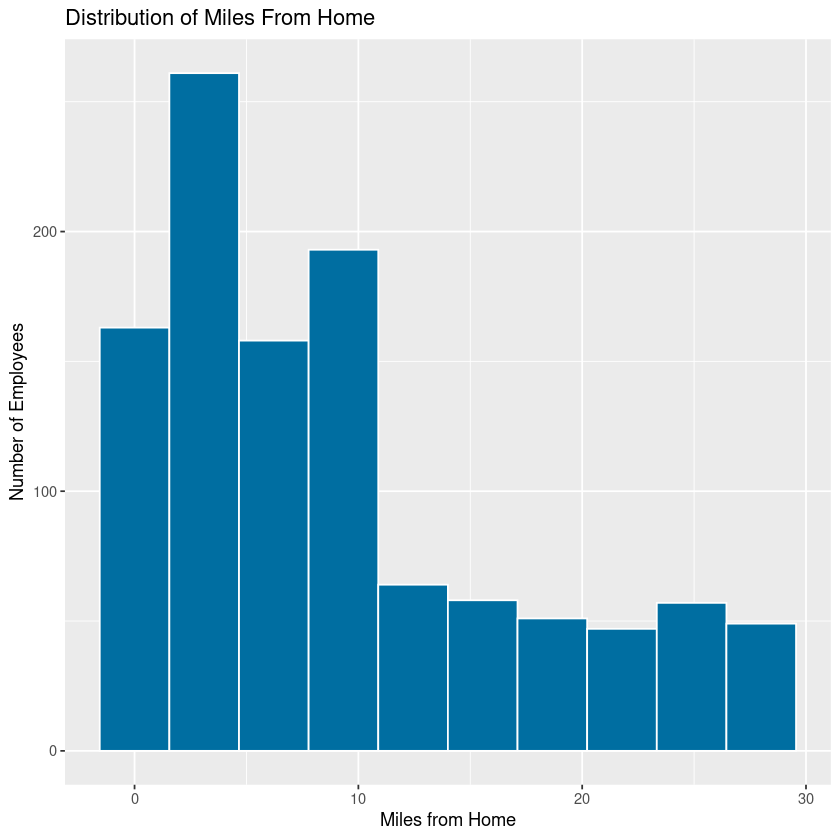

In [15]:
ggplot(data = employee_training, mapping = aes(x = miles_from_home)) +
  geom_histogram(fill = '#006EA1', color = 'white', bins = 10) +
  labs(title = 'Distribution of Miles From Home',
       x = 'Miles from Home',
       y = 'Number of Employees')


<br> <br>

Now let's transform this variable in the training data with the
Yeo-Johnson transformation and look at the resulting values.

<br>


In [16]:
employee_recipe %>% 
  step_YeoJohnson(miles_from_home) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = NULL)


job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Director,117226.84,50,1.4023075,No
Senior Manager,83519.59,48,1.1086530,No
Senior Manager,88555.65,44,1.4023075,No
Director,122280.88,47,3.3060905,No
Senior Manager,94642.18,50,3.2630511,No
Director,122820.53,46,2.9006365,No
Manager,69565.51,48,2.8371355,No
Associate,41985.50,48,3.3873111,No
Director,117368.60,48,3.0711804,No


<br> <br>

Let's plot the distribution of the results. In the code below, I pipe
the results from above into `ggplot`. Although the results are not
perfectly symmetric, they are much better than the original distribution
of values. In general, I recommend performing this step on all numeric
predictors.

<br>


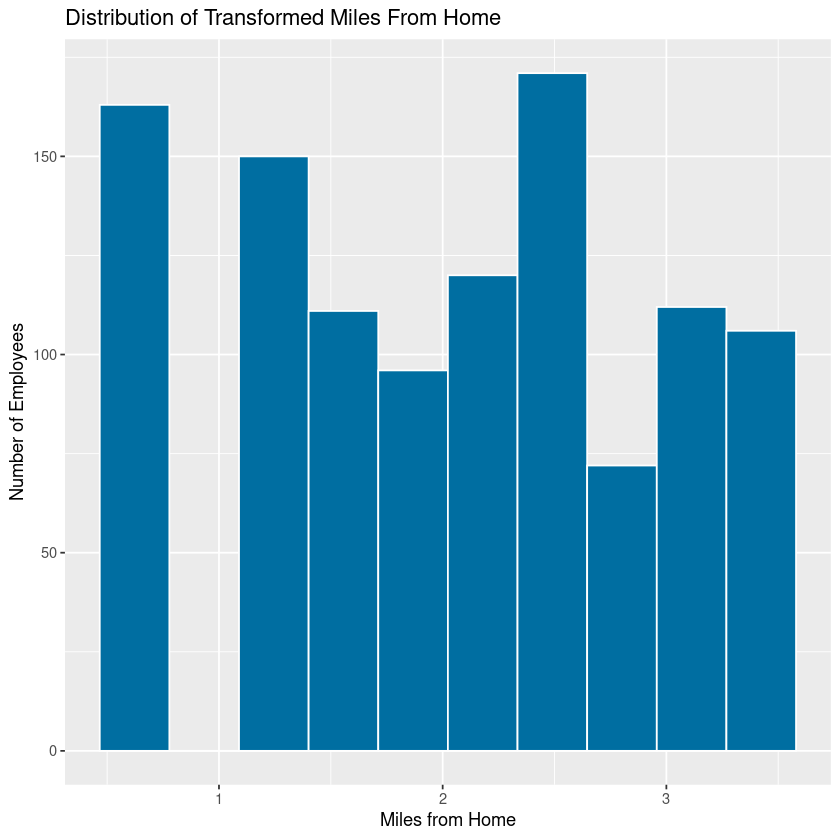

In [17]:
employee_recipe %>% 
  step_YeoJohnson(miles_from_home) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = NULL) %>%
  
  ggplot(mapping = aes(x = miles_from_home)) +
  geom_histogram(fill = '#006EA1', color = 'white', bins = 10) +
  labs(title = 'Distribution of Transformed Miles From Home',
       x = 'Miles from Home',
       y = 'Number of Employees')


### Removing Highly Correlated Predictors

Another common feature engineering task is to remove highly correlated
predictor variables. High correlation among numeric predictors is known
as multicollinearity and can cause trouble in the model fitting process.

<br>


Correlation measures the **linear** relationship between two numeric datasets.

Ranges from -1 to 1

Below are some common patterns that would appear in a scatter plot for different correlation values

<br>
<br>
<p align="center">
<img 
  src="./files/negative_correlation.png" 
  alt="Negative Correlation" 
  width="430"
/img>
</p>
<br>
<br>
<br>

<p align="center">
<img 
  src="./files/positive_correlation.png" 
  alt="Positive Correlation" 
  width="430"
/img>
</p>
<br>
<br>


<br>
<p align="center">
<img 
  src="./files/zero_correlation.png" 
  alt="Zero Correlation" 
  width="430"
/img>
</p> 
<br>
<br>


**Beware**: A correlation of zero does not imply a lack of association/relationship between two numeric datasets
<br>

<p align="center">
<img 
  src="./files/non_linear_relationship.png" 
  alt="Non Linear Relationship" 
  width="430"
/img>
</p>

To remove correlated numeric predictors, use `step_corr()`. The
`step_corr()` function has a `threshold` argument that will remove
correlations at that level. The default threshold is set to 0.9. This
corresponds to correlations at 0.9 or greater and -0.9 or less.

Let's use the `step_corr()` function in on our `employee_recipe`.

The correlation between `salary` and `weekly_hours` in our
`employee_training` data is -0.19. With the default threshold, no
variables will be removed. If we change the threshold to 0.15, however,
`weekly_hours` is removed from new data.


In [18]:
# Default threshold of 0.9
employee_recipe %>% 
  step_corr(all_numeric(), -all_outcomes()) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = employee_test)


job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<int>,<fct>
Senior Manager,85576.44,42,8,No
Associate,36634.73,46,2,No
Director,124537.85,51,27,No
Manager,63876.58,57,24,Yes
Senior Manager,84196.93,52,2,No
Director,116974.14,49,7,No
Senior Manager,93320.48,57,1,Yes
Senior Manager,82753.17,55,2,No
Director,122196.65,46,1,No


<br>

With a threshold of 0.15, `weekly_hours` is removed from our new data,
`employee_test`.

In [19]:
employee_recipe %>% 
  step_corr(all_numeric(), -all_outcomes(), threshold = 0.15) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = employee_test)


job_level,salary,miles_from_home,left_company
<fct>,<dbl>,<int>,<fct>
Senior Manager,85576.44,8,No
Associate,36634.73,2,No
Director,124537.85,27,No
Manager,63876.58,24,Yes
Senior Manager,84196.93,2,No
Director,116974.14,7,No
Senior Manager,93320.48,1,Yes
Senior Manager,82753.17,2,No
Director,122196.65,1,No


### Putting It All Together

To demonstrate how a full recipe is specified, let's create a recipe
object called `employee_numeric` that will train the following steps on
our `employee_training` data:

-   remove highly correlated predictors
-   remove skewness from all numeric predictors
-   center and scale all numeric predictors

In [20]:
employee_numeric <- recipe(left_company ~ .,
                           data = employee_training) %>% 
                    step_corr(all_numeric(), -all_outcomes()) %>%  
                    step_YeoJohnson(all_numeric(), -all_outcomes()) %>% 
                    step_normalize(all_numeric(), -all_outcomes()) %>% 
                    prep(training = employee_training)


<br>

Now that we have our trained recipe, we can apply the transformations to
our training and test data with `bake()`.

<br>


In [21]:
processed_employee_training <- employee_numeric %>% 
                               bake(new_data = NULL)

processed_employee_test <- employee_numeric %>% 
                           bake(new_data = employee_test)


<br>



In [22]:
# View results
processed_employee_training


job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Director,0.68414147,0.18842246,-0.6893837,No
Senior Manager,-0.18023665,-0.28500390,-1.0206302,No
Senior Manager,-0.03585973,-1.49132856,-0.6893837,No
Director,0.79668354,-0.55087274,1.4581104,No
Senior Manager,0.13049027,0.18842246,1.4095614,No
Director,0.80848909,-0.83890999,1.0007525,No
Manager,-0.61839413,-0.28500390,0.9291226,No
Associate,-1.73480664,-0.28500390,1.5497283,No
Director,0.68734820,-0.28500390,1.1931285,No


<br>



In [23]:
# View results
processed_employee_test


job_level,salary,weekly_hours,miles_from_home,left_company
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Senior Manager,-0.12048713,-2.26540170,0.25287460,No
Associate,-2.01408819,-0.83890999,-1.02063016,No
Director,0.84579597,0.39951479,1.59306257,No
Manager,-0.81649216,1.39208710,1.45811039,Yes
Senior Manager,-0.16043742,0.59556518,-1.02063016,No
Director,0.67841787,-0.03919571,0.11523127,No
Senior Manager,0.09507692,1.39208710,-1.48482807,Yes
Senior Manager,-0.20278789,1.10604964,-1.02063016,No
Director,0.79483727,-0.83890999,-1.48482807,No


## Processing Categorical Variables

For a large number of machine learning algorithms, all data in a feature
matrix must be numeric. Therefore, any character or factor variables in
a data frame must be transformed into numbers.

How is this done? The two primary methods are **dummy variable** creation
and **one-hot encoding**. Both methods are performed by the `step_dummy()`
function.

Let's see an example of both methods using our `employee_recipe` object.
We will transform the `job_level` variable using one-hot encoding and
dummy variables.

<br>

### One-Hot Encoding

<br>

<p align="center">
<img 
  src="./files/one_hot_encoding.png" 
  width="650"
/img>
</p>

<br>
<br>


The `job_level` variable in `employee_training` has 5 unique values:
Associate, Manager, Senior Manager, Director, and Vice President.

One-hot encoding will produce 5 new variables that are either 0 or 1
depending on whether the value was present in the `job_level` row.

The new variables are created with the following naming convention:
`variable_name_level`

For example, `job_level_Associate` will be one variable that is created.
If the value of `job_level` for any row in the data is "Associate", then
this new variable will be equal to 1 and 0 otherwise.

Let's see how we can do this with `step_dummy()`


In [24]:
# One-hot encode job_level
employee_recipe %>% 
  step_dummy(job_level, one_hot = TRUE) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = NULL)


salary,weekly_hours,miles_from_home,left_company,job_level_Associate,job_level_Manager,job_level_Senior.Manager,job_level_Director,job_level_Vice.President
<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
117226.84,50,3,No,0,0,0,1,0
83519.59,48,2,No,0,0,1,0,0
88555.65,44,3,No,0,0,1,0,0
122280.88,47,24,No,0,0,0,1,0
94642.18,50,23,No,0,0,1,0,0
122820.53,46,16,No,0,0,0,1,0
69565.51,48,15,No,0,1,0,0,0
41985.50,48,26,No,1,0,0,0,0
117368.60,48,19,No,0,0,0,1,0


### Dummy Variables

<br>

<p align="center">
<img 
  src="./files/dummy_encoding.png" 
  width="500"
/img>
</p>

<br>
<br>

Creating dummy variables is similar to one-hot encoding, except that one
level is always left out. Therefore, if we create dummy variables from
the `job_level()` function, we will have 4 new variables instead of 5.

This method is generally preferred to one-hot encoding because many
statistical models will fail with one-hot encoding. This is because it
creates multicollinearity in the one-hot encoded variables.

In fact, the default of `step_dummy()` is to have `one_hot` set to
FALSE. This is what I recommend for most machine learning applications.

Let's see the difference when we use the default settings of
`step_dummy()`. Notice that `job_level_Associate` is now excluded.

<br>


In [25]:
employee_recipe %>% 
  step_dummy(job_level) %>% 
  prep(training = employee_training) %>% 
  bake(new_data = NULL)


salary,weekly_hours,miles_from_home,left_company,job_level_Manager,job_level_Senior.Manager,job_level_Director,job_level_Vice.President
<dbl>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
117226.84,50,3,No,0,0,1,0
83519.59,48,2,No,0,1,0,0
88555.65,44,3,No,0,1,0,0
122280.88,47,24,No,0,0,1,0
94642.18,50,23,No,0,1,0,0
122820.53,46,16,No,0,0,1,0
69565.51,48,15,No,1,0,0,0
41985.50,48,26,No,0,0,0,0
117368.60,48,19,No,0,0,1,0


## Creating a Feature Engineering Pipeline

When creating feature engineering recipes with many steps, we have to
keep in mind that the **transformations are carried out in the order
that we enter them**.

So if we use `step_dummy()` before `step_normalize()` our dummy
variables will be normalized because they are numeric at the point when
`step_normalize()` is called.

To make sure we don't get any unexpected results, it's best to use the
following ordering of high-level transformations:

1.  Correlation filters and skewness transformations -
    `step_YeoJohnson()` and `step_corr()`
2.  Centering, scaling, or normalization on numeric predictors
3.  Dummy variables for categorical data

<br>

Let's put together all that we have learned to create the following
feature engineering pipeline on the `employee_training` data:

-   Correct for skewness on all numeric predictors
-   Normalize all numeric predictors
-   Create dummy variables for all character or factor predictors (we
    can use the all_nominal() selector for this)

<br>


In [30]:
employee_transformations <- recipe(left_company ~ .,
                                   data = employee_training)  %>% 
                            # Transformation steps
                            step_YeoJohnson(all_numeric(), -all_outcomes()) %>%
                            step_normalize(all_numeric(), -all_outcomes()) %>% 
                            step_dummy(all_nominal(), -all_outcomes()) %>% 
                            # Train transformations on employee_training
                            prep(training = employee_training)

# Apply to employee_test
employee_transformations %>% 
  bake(new_data = employee_test)
                            


salary,weekly_hours,miles_from_home,left_company,job_level_Manager,job_level_Senior.Manager,job_level_Director,job_level_Vice.President
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
-0.12048713,-2.26540170,0.25287460,No,0,1,0,0
-2.01408819,-0.83890999,-1.02063016,No,0,0,0,0
0.84579597,0.39951479,1.59306257,No,0,0,1,0
-0.81649216,1.39208710,1.45811039,Yes,1,0,0,0
-0.16043742,0.59556518,-1.02063016,No,0,1,0,0
0.67841787,-0.03919571,0.11523127,No,0,0,1,0
0.09507692,1.39208710,-1.48482807,Yes,0,1,0,0
-0.20278789,1.10604964,-1.02063016,No,0,1,0,0
0.79483727,-0.83890999,-1.48482807,No,0,0,1,0
